In [1]:
import sys
sys.path.append('../')

import json
import random
import numpy as np
import matplotlib.pyplot as plt
from baseline import ner_viterbi

In [2]:
with open('../data/tagged_positive_sentences.json', 'r') as file:
    positive_data = json.load(file)
    
with open('../data/tagged_negative_sentences.json', 'r') as file:
    negative_data = json.load(file)

with open('../data/tagged_medical_sentences.json', 'r') as file:
    medical_data = json.load(file)

In [3]:
positive_tokens = []
positive_pos_tags = []
positive_ner_tags = []
for sent in positive_data:
    positive_tokens.append(sent['tokens'])
    positive_pos_tags.append(sent['pos_tags'])
    positive_ner_tags.append(sent['ner_tags'])

negative_tokens = []
negative_pos_tags = []
negative_ner_tags = []
for sent in negative_data:
    negative_tokens.append(sent['tokens'])
    negative_pos_tags.append(sent['pos_tags'])
    negative_ner_tags.append(sent['ner_tags'])

medical_tokens = []
medical_pos_tags = []
medical_ner_tags = []
for sent in medical_data:
    medical_tokens.append(sent['tokens'])
    medical_pos_tags.append(sent['pos_tags'])
    medical_ner_tags.append(sent['ner_tags'])

In [4]:
def create_training_sets(positive_data, negative_data, specifications, total_samples=10000):
    train_sets = []

    for pos_ratio in specifications:
        if 0 <= pos_ratio <= 1:
            # Calculate the number of positive and negative samples
            num_positive = int(total_samples * pos_ratio)
            num_negative = int(total_samples * (1-pos_ratio) + 1) # +1 Guarantees that there will be 10000
        else:
            continue

        # Randomly sample
        sampled_positive = random.sample(positive_data, num_positive)
        sampled_negative = random.sample(negative_data, num_negative)
        combined_samples = sampled_positive + sampled_negative
        random.shuffle(combined_samples)

        # Add to the list of training sets
        train_sets.append(combined_samples)

    return train_sets

In [5]:
specifications = [1, .95, .9, .85, .8, .75, .7, .65, .6, .55, .5]
train_sets = create_training_sets(positive_data, negative_data, specifications)

for i, train_set in enumerate(train_sets):
    print(f"Dataset {i+1}: {len(train_set)} samples")

Dataset 1: 10001 samples
Dataset 2: 10001 samples
Dataset 3: 10000 samples
Dataset 4: 10001 samples
Dataset 5: 10000 samples
Dataset 6: 10001 samples
Dataset 7: 10001 samples
Dataset 8: 10001 samples
Dataset 9: 10001 samples
Dataset 10: 10001 samples
Dataset 11: 10001 samples


In [6]:
def run_test(data, test_data):
    tokens = []
    pos_tags = []
    ner_tags = []
    for sent in data:
        tokens.append(sent['tokens'])
        pos_tags.append(sent['pos_tags'])
        ner_tags.append(sent['ner_tags'])

    test_tokens = []
    test_pos_tags = []
    test_ner_tags = []
    for sent in test_data:
        test_tokens.append(sent['tokens'])
        test_pos_tags.append(sent['pos_tags'])
        test_ner_tags.append(sent['ner_tags'])

    # Train HMM
    transition_probs, emission_probs, label_priors, vocab, label_set = ner_viterbi.train_hmm_with_separate_inputs(tokens, pos_tags, ner_tags)
    print("HMM trained")

    correct = [0,0]
    matrix = [[0,0],[0,0]]
    for i in range(len(test_tokens)):
        sequence_with_tags = list(zip(test_tokens[i], test_pos_tags[i]))
        predicted_labels = ner_viterbi.viterbi_with_tokens_and_pos_tags(sequence_with_tags, transition_probs, emission_probs, label_priors, vocab, label_set)
        for j in range(len(predicted_labels)):
            correct[predicted_labels[j] == test_ner_tags[i][j]] += 1
            matrix[predicted_labels[j] == 'O'][test_ner_tags[i][j] == 'O'] += 1
    print("Test done")

    return correct, matrix

In [7]:
def test_iterator(train_sets, test_set):
    out = []
    for index, train in enumerate(train_sets):
        print(index)
        out.append(run_test(train, test_set))
    return out

In [8]:
outputs = test_iterator(train_sets, medical_data)

0
HMM trained
Test done
1
HMM trained
Test done
2
HMM trained
Test done
3
HMM trained
Test done
4
HMM trained
Test done
5
HMM trained
Test done
6
HMM trained
Test done
7
HMM trained
Test done
8
HMM trained
Test done
9
HMM trained
Test done
10
HMM trained
Test done


In [9]:
def calculate_stats(correct, matrix):
    acc = correct[1]/sum(correct)
    precision = matrix[0][0]/(matrix[0][0] + matrix[0][1])
    recall = matrix[0][0]/(matrix[0][0] + matrix[1][0])
    f1 = 2/(1/precision + 1/recall)
    return acc, precision, recall, f1

In [10]:
accs, precs, recs, f1s = [], [], [], []
for correct, matrix in outputs:
    acc, precision, recall, f1 = calculate_stats(correct, matrix)
    accs.append(acc)
    precs.append(precision)
    recs.append(recall)
    f1s.append(f1)

In [11]:
specifications

[1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]

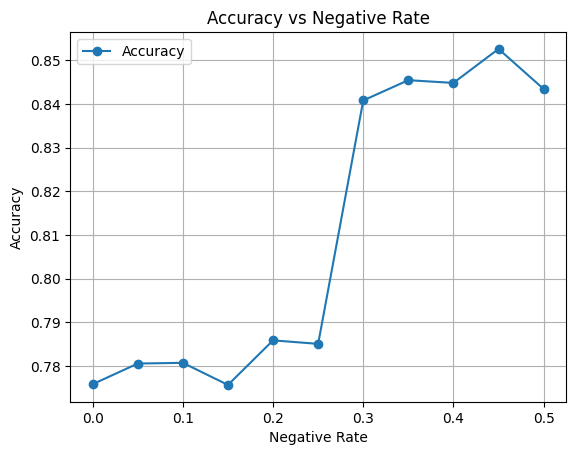

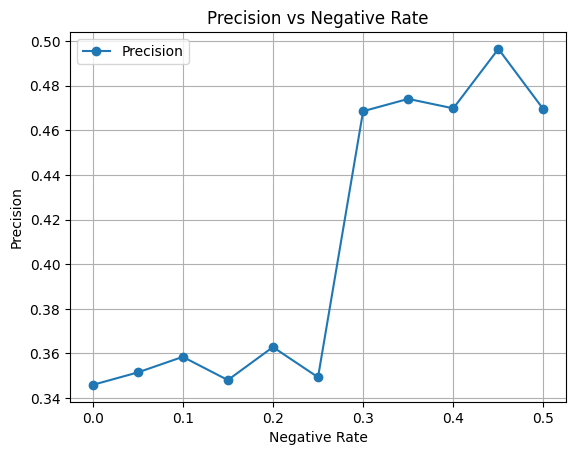

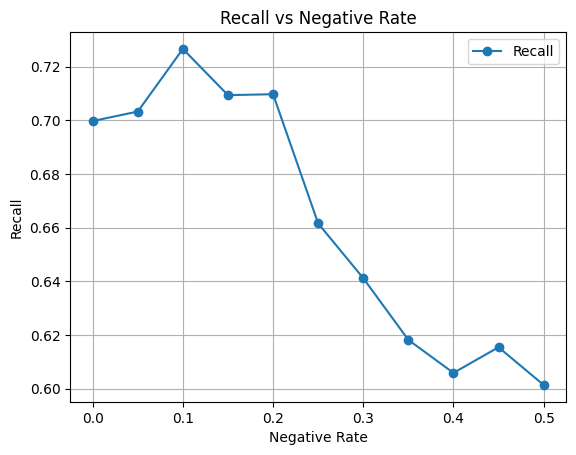

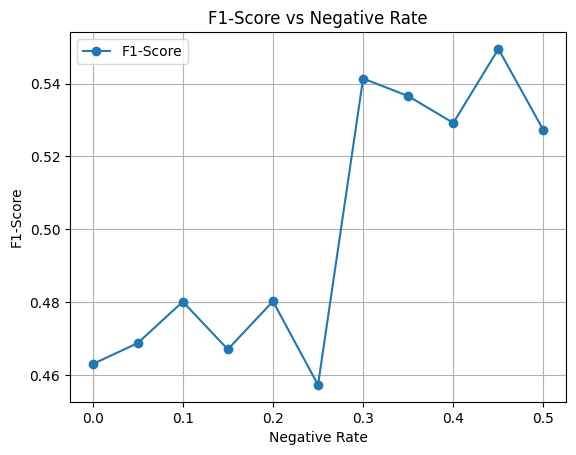

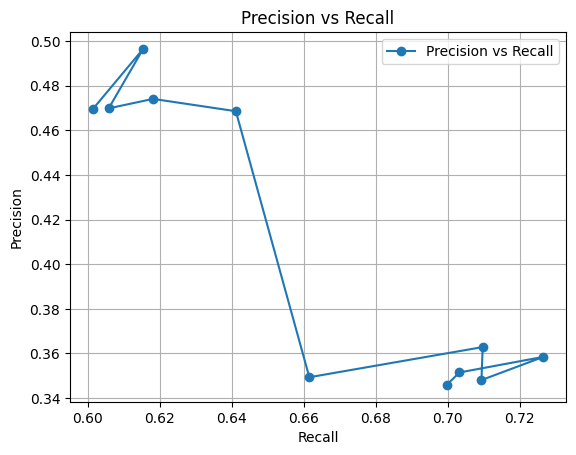

In [12]:
neg_specifications = 1-np.array(specifications)

# Create individual plots for each metric
metrics = {
    "Accuracy": accs,
    "Precision": precs,
    "Recall": recs,
    "F1-Score": f1s,
}

# Plot each metric vs Negative Rate
for metric_name, values in metrics.items():
    plt.figure()
    plt.plot(neg_specifications, values, marker='o', label=metric_name)
    plt.title(f"{metric_name} vs Negative Rate")
    plt.xlabel("Negative Rate")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.legend()
    plt.show()

# Create a precision vs recall plot
plt.figure()
plt.plot(recs, precs, marker='o', label="Precision vs Recall")
plt.title("Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()
